# 9. Classification: practice

Now that we have all the necessary parts together we can try to train a network on an actual dataset. Here we use the [QuickDraw](https://quickdraw.withgoogle.com/) dataset, composed of thousands of doodles made by people across the world. The drawings come from a game where people are given a word and have to sketch it correctly as fast as possible. Those drawings were collected by Google and publicly released as dataset: we have tens of categories and for each thousands of doodles available in different formats. Here we use a format where drawings have been turned into Numpy files that are easily readable.

In this notebook we will try to train a classifying network and try to investigage more in depth the learning process the network.

In [541]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from pathlib import Path
import skimage.io
import numpy as np
import matplotlib.pyplot as plt

In [542]:
# set path containing data folder or use default for Colab (/gdrive/My Drive)
local_folder = "../"
import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/guiwitz/DLImaging/master/utils/check_colab.py', 'check_colab.py')
from check_colab import set_datapath
colab, datapath = set_datapath(local_folder)

We check if a GPU is available:

In [543]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data loading

Each category is stored in a .npy file. We use here only three categories. Let's import one to see how it looks: 

In [544]:
piano = np.load(datapath.joinpath('data/quickdraw/full_numpy_bitmap_piano.npy'))

In [545]:
piano.shape

(116870, 784)

We have 116870 images of size 28x28 saved as linear vectors of size 784. If we want see an image, we therefore first have to ```reshape``` it:

In [546]:
im_reshape = np.reshape(piano[3], (28,28))

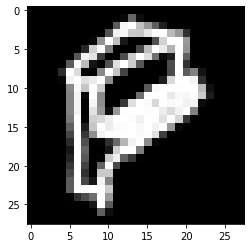

In [547]:
plt.imshow(im_reshape, cmap='gray')

Now our goal is to create an image generator that will randomly draw images from each category. First we find all categories available:

In [548]:
folders = list(datapath.joinpath('data/quickdraw').glob('*npy'))

In [549]:
folders

[PosixPath('../data/quickdraw/full_numpy_bitmap_violin.npy'),
 PosixPath('../data/quickdraw/full_numpy_bitmap_piano.npy'),
 PosixPath('../data/quickdraw/full_numpy_bitmap_angel.npy')]

We can create our category name from the file path:

In [550]:
label = folders[0].name.split('_')[-1][:-4]
label

'violin'

Now we decide to use a certain number of images for each category and create arrays to store them. Since we read to files sequentially, we will have blocks of data with certain categories and when we train, we would train with batches containing only a single class at a time which is bad. We can either shuffle data at import time, or we can do it when we call the ```Dataloader``` by *shuffling* the batch contents (as done here).

In [551]:
data = np.concatenate([np.load(f)[0:50000] for f in folders])

We assign a label to each category and create a dictionary to remember which number if which category:

In [552]:
label_dict = {i:f.name.split('_')[-1][:-4] for i, f in enumerate(folders)}
label_dict

{0: 'violin', 1: 'piano', 2: 'angel'}

In [553]:
labels = np.concatenate([[ind for i in range(50000)] for ind, f in enumerate(folders)])

We use now a transform to turn the images into tensors. We can use the same transform later e.g. to add augmentation. We actually define two transforms: one for training and one for validation/inference, as for the latter we don't need augmentation.

In [554]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

train_transformations = transforms.Compose([
    transforms.ToTensor(),
])

valid_transformations = transforms.Compose([
    transforms.ToTensor(),
])

In [555]:
class Drawings(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        x = np.reshape(x, (28,28))
        y = self.targets[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.targets)

We now create two instances of our ```Drawings``` object, one for training and one for validation. Of course they initially contain the same data:

In [556]:
draw_train = Drawings(data, labels, train_transformations)
draw_valid = Drawings(data, labels, valid_transformations)

We define the sizes of test/validation sets:

In [557]:
train_size = int(0.8 * len(draw_train))
valid_size = len(draw_train)-train_size

And now we create a shuffled list of all possible indices and split it into two parts, one for validation (indices 0 to test_size) and one for validation (test_size+1 to end).

In [558]:
random_indices = np.random.permutation(np.arange(len(draw_train)))

train_indices = random_indices[0:train_size]
valid_indices = random_indices[train_size::]

Now that we have non-overlapping sets of indices we can use thos to sample our datasets and be sure that we won't re-use the same images for training and validation. For that we use a ```SubsetRandomSampler```:

In [559]:
from torch.utils.data import SubsetRandomSampler

In [560]:
batch_size = 10

train_loader = DataLoader(draw_train, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
valid_loader = DataLoader(draw_valid, batch_size=batch_size, sampler=SubsetRandomSampler(valid_indices))

In [561]:
len(train_loader)

12000

In [562]:
len(valid_loader)

3000

## Control

Before we proceed we want to make sure that our data handling works properly. **Above all** we really want to make sure that we don't mix training and validation sets which would destroy our control of over-fitting.

We put here together the entire above code and turn it into a function where we have flexibility over the number of images and batchsisze to use:

In [563]:
def create_loaders(num_data, batch_size):

    data = np.concatenate([np.load(f)[0:num_data] for f in folders]) #check everything works with tiny set
    labels = np.concatenate([[ind for i in range(num_data)] for ind, f in enumerate(folders)]) #check everything works with tiny set

    draw_train = Drawings(data, labels, train_transformations)
    draw_valid = Drawings(data, labels, valid_transformations)

    train_size = int(0.8 * len(draw_train))
    valid_size = len(draw_train)-train_size

    random_indices = np.random.permutation(np.arange(len(draw_train)))
    train_indices = random_indices[0:train_size]
    valid_indices = random_indices[train_size::]

    train_loader = DataLoader(draw_train, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
    valid_loader = DataLoader(draw_valid, batch_size=batch_size, sampler=SubsetRandomSampler(valid_indices))
    
    return train_loader, valid_loader

We use here just 6 images per category and a batch size of 2:

In [564]:
train_loader, valid_loader = create_loaders(6, 2)

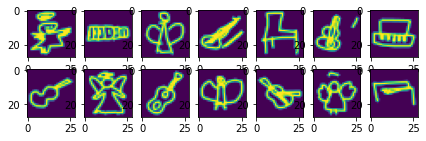

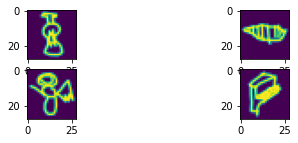

In [565]:
fig, ax = plt.subplots(2,7, figsize=(7,2))
for ind, a in enumerate(train_loader):
    ax[0, ind].imshow(a[0][0,0])
    ax[1, ind].imshow(a[0][1,0])
fig, ax = plt.subplots(2,2, figsize=(7,2))
for ind, a in enumerate(valid_loader):
    ax[0,ind].imshow(a[0][0,0])
    ax[1,ind].imshow(a[0][1,0])

So everything seems to work fine. We dont' have training/validation duplicates!

## Network

We define again a simple network with just three layers using the ```LightningModule``` and adding the necessary parts, i.e. ```forward```, ```training_step```, ```validation_step``` and ```configure_optimizers```:

In [566]:
import pytorch_lightning as pl

In [572]:
class SimpleNet(pl.LightningModule):
    def __init__(self, nbclasses):
        super(SimpleNet, self).__init__()
        
        self.lin1 = nn.Linear(28*28, 100)
        self.lin2 = nn.Linear(100, 100)
        self.lin3 = nn.Linear(100, nbclasses)
        
        self.loss = nn.CrossEntropyLoss()

    # x represents our data
    def forward(self, x):
        
        #linearize data
        x = x.flatten(start_dim=1)
        # Pass data through series of linear + ReLU layers
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.relu(x)
        x = self.lin3(x)
        
        return x
        
    def training_step(self, batch, batch_idx):
        
        x, y = batch
        output = self(x)
        loss = self.loss(output, y)
        
        self.log('loss', loss, on_epoch=True, prog_bar=True, logger=True)

        return loss
    
    def validation_step(self, batch, batch_idx):
        
        x, y = batch
        output = self(x)
        accuracy = (torch.argmax(output,dim=1) == y).sum()/len(y)

        self.log('accuracy', accuracy, on_epoch=True, prog_bar=True, logger=True)
        
        return accuracy
        
    def configure_optimizers(self):
        
        return torch.optim.Adam(self.parameters(), lr=1e-3)

We have three different types of images:

In [573]:
mynet = SimpleNet(nbclasses=3)

Now we generate our actual larger dataset:

In [574]:
train_loader, valid_loader = create_loaders(10000, 10)

In [575]:
test = next(iter(valid_loader))
test[0].size()

torch.Size([10, 1, 28, 28])

In [576]:
output = mynet(test[0])
output.size()

torch.Size([10, 3])

In [577]:
list(mynet.named_children())

[('lin1', Linear(in_features=784, out_features=100, bias=True)),
 ('lin2', Linear(in_features=100, out_features=100, bias=True)),
 ('lin3', Linear(in_features=100, out_features=3, bias=True)),
 ('loss', CrossEntropyLoss())]

## Training

Finally we use Lightning to train our network for a few epochs:

In [578]:
trainer = pl.Trainer(max_epochs=2)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


In [579]:
del mynet
mynet = SimpleNet(nbclasses=3)

In [580]:
trainer.fit(mynet, train_dataloader=train_loader, val_dataloaders=valid_loader)


  | Name | Type             | Params
------------------------------------------
0 | lin1 | Linear           | 78.5 K
1 | lin2 | Linear           | 10.1 K
2 | lin3 | Linear           | 303   
3 | loss | CrossEntropyLoss | 0     
------------------------------------------
88.9 K    Trainable params
0         Non-trainable params
88.9 K    Total params


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

We reach a good accuracy. Let's visualize the validation set:

In [521]:
image, lab = next(iter(valid_loader))

In [522]:
pred = mynet(image)
pred = pred.argmax(dim=1)

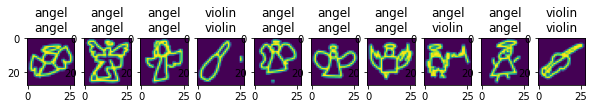

In [523]:
fig, ax = plt.subplots(1,10, figsize=(10,2))
for ind, im in enumerate(image):
    ax[ind].imshow(im[0])
    title = label_dict[lab[ind].item()] + '\n' + label_dict[pred[ind].item()]
    ax[ind].set_title(title)

## Using slightly different data

We have trained our network on the violin, piano and angel categories. Let's see what happends if we replace the angle category by cello:

In [581]:
folders = list(datapath.joinpath('data/quickdraw_alt').glob('*npy'))
label_dict = {i:f.name.split('_')[-1][:-4] for i, f in enumerate(folders)}

train_loader, valid_loader = create_loaders(10000, 10)

In [585]:
image, lab = next(iter(valid_loader))

In [586]:
pred = mynet(image)
pred = pred.argmax(dim=1)

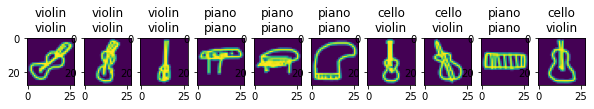

In [587]:
fig, ax = plt.subplots(1,10, figsize=(10,2))
for ind, im in enumerate(image):
    ax[ind].imshow(im[0])
    title = label_dict[lab[ind].item()] + '\n' + label_dict[pred[ind].item()]
    ax[ind].set_title(title)

Cello and violin beeing very close, we see that our network consistently predicts cellos as being violins. It would require little effort to re-train the existing network for that new category. We will see later that this is called fine-tuning.